
# pPXF: Fitting integral-field data

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

### MODIFICATION HISTORY

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022
* V1.1.0: MC, Oxford, 28 November 2023: Updated for pPXF 9.0 using the new `sps_util`.

___

In [1]:
from pathlib import Path
from urllib import request

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

## Function to read the MUSE cube

In [2]:
class read_data_cube:
    def __init__(self, filename, wave_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cuberr = self.cuberr[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cuberr, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize
        y = (row - row[jm])*self.pixsize

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)    # create array of spectra [npix, nx*ny]
        variance = cuberr.reshape(npix, -1) # create array of spectra [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)  

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """
        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data  
        cuberr = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CDELT3']*np.arange(cube.shape[0])

        self.cube = cube
        self.cuberr = cuberr
        self.wave = wave
        self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.pixsize = abs(head["CDELT1"])*3600    # 0.2"

###############################################################################

## Function to iteratively clip the outliers

In [3]:
def clip_outliers(galaxy, bestfit, mask):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma in relative
    error until the bad bins don't change any more. This function uses eq.(34)
    of Cappellari (2023) https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C
    """
    while True:
        scale = galaxy[mask] @ bestfit[mask]/np.sum(bestfit[mask]**2)
        resid = scale*bestfit[mask] - galaxy[mask]
        err = robust_sigma(resid, zero=1)
        ok_old = mask
        mask = np.abs(bestfit - galaxy) < 3*err
        if np.array_equal(mask, ok_old):
            break
            
    return mask

## Function to fit the stellar kinematics

The following function fits the spectrum with `pPXF` while masking the gas
emission lines, then iteratively clips the outliers and finally refit the
spectrum with `pPXF` on the cleaned spectrum.

In [4]:
def ppxf_fit_and_clean(templates, galaxy, velscale, start, mask0, lam, lam_temp, plot=True, quiet=False):
    """
    This is a simple pPXF wrapper. It perform two pPXF fits: the first one
    serves to estimate the scatter in the spectrum and identify the outlier
    pixels. The second fit uses the mask obtained from the first fit to exclude
    the outliers. The general approach used in this function is described in
    Sec.6.5 of Cappellari (2023) https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C
    """
    mask = mask0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=4, mdegree=-1, lam=lam, lam_temp=lam_temp,
              mask=mask, quiet=quiet)

    if plot:
        plt.figure(figsize=(20, 3))
        plt.subplot(121)
        pp.plot()
        plt.title("Initial pPXF fit before outliers removal")

    mask = clip_outliers(galaxy, pp.bestfit, mask)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    mask &= mask0
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=4, mdegree=-1, lam=lam, lam_temp=lam_temp,
              mask=mask, quiet=quiet)
    
    optimal_template = templates.reshape(templates.shape[0], -1) @ pp.weights
    
    resid = (pp.galaxy - pp.bestfit)[pp.goodpixels]
    sn = np.nanmedian(pp.galaxy[pp.goodpixels])/robust_sigma(resid)

    if plot:
        plt.subplot(122)
        pp.plot()

    return pp, optimal_template, sn

## Read the data cube and Voronoi bin the data

I only extract the cube over the wavelength region where there are emission
lines and where the spectrum is less contaminated by sky residuals.

In [5]:
lam_range_temp = [3540, 7409]   # Focus on optical region
redshift = 0.002895             # redshift estimate from NED
sn_min = 0

Read the input data. If the data file does not exists, download it from my GitHub page.

In [6]:
objfile = Path('LVS_JWST_workshop_rodeo_cube.fits')     # NGC1386
if not objfile.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_examples/main/" + objfile.name
    request.urlretrieve(url, objfile)

s = read_data_cube(objfile, lam_range_temp, redshift)

In this example I request an excessively large `target_sn=350` to speed up
the calculation. This generates only 9 Voronoi bins. But in a real situation
the spatially binned data cube will contain over a hundred Voronoi bins e.g.
with `target_sn=60`.

In [7]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
target_sn = 350
# target_sn = 60

Perform Voronoi binning with the method of [Cappellari & Copin (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.342..345C)

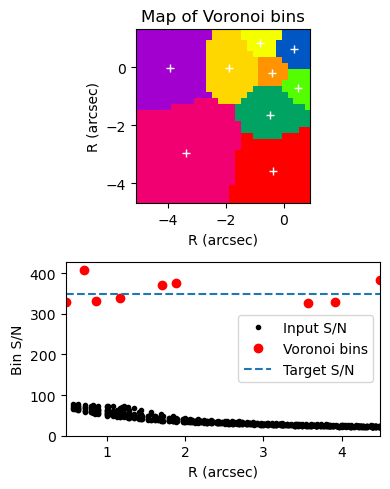

In [8]:
plt.figure(figsize=(4, 5))
bin_num = voronoi_2d_binning(s.x, s.y, signal, noise, target_sn, plot=1, quiet=1)[0]
plt.tight_layout()

Here is the result of this Notebook when using a proper Voronoi binning with `target_sn=60`
<br>
![](https://raw.githubusercontent.com/micappe/ppxf_examples/main/binning.png)

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for
four SPS. One can just uncomment one of the four models below. The
included files are only a subset of the SPS that can be produced with the
models, and one should use the relevant software/website to produce
different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [9]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

Read SPS models file from my GitHub if not already in the pPXF package dir. I
am not distributing the templates with pPXF anymore. The SPS model files are
also available at [this GitHub page](https://github.com/micappe/ppxf_data).

In [10]:
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

In [11]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, s.velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = sps.templates, sps.ln_lam_temp

The stellar templates are reshaped into a 2-dim array with each spectrum as a
column, however we save the original array dimensions, which are needed to
specify the regularization dimensions


In [12]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

See the pPXF documentation for the keyword `regul`, for an explanation of the following two lines.


In [13]:
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

## Fit templates and stellar kinematics in Voronoi binned data

Create a mask for the main gas emission lines in the rest frame

In [14]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(s.ln_lam_gal, lam_range_temp, width=1000)

Fit the stellar kinematics and determine the optimal stellar template for
every Voronoi bin

 Best Fit:       Vel     sigma
 comp.  0:       -11       115
chi2/DOF: 2.320e+04; DOF: 2373; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       -13       118
chi2/DOF: 5691.; DOF: 2238; degree = 4; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/150
Weighted <lg_age> [yr]: 9.16
Weighted <[M/H]>: -0.329
Voronoi bin 1 / 9; $\sigma$=118 km/s; S/N=66.5
##############################################################################
 Best Fit:       Vel     sigma
 comp.  0:        62       114
chi2/DOF: 6803.; DOF: 2373; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:        68       118
chi2/DOF: 2191.; DOF: 2287; degree = 4; mdegree = 0
method = capfit

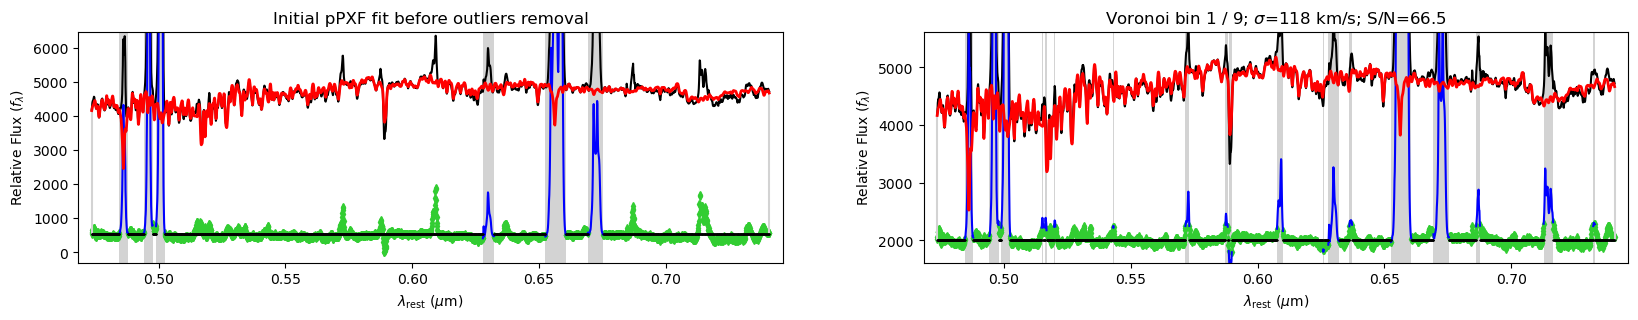

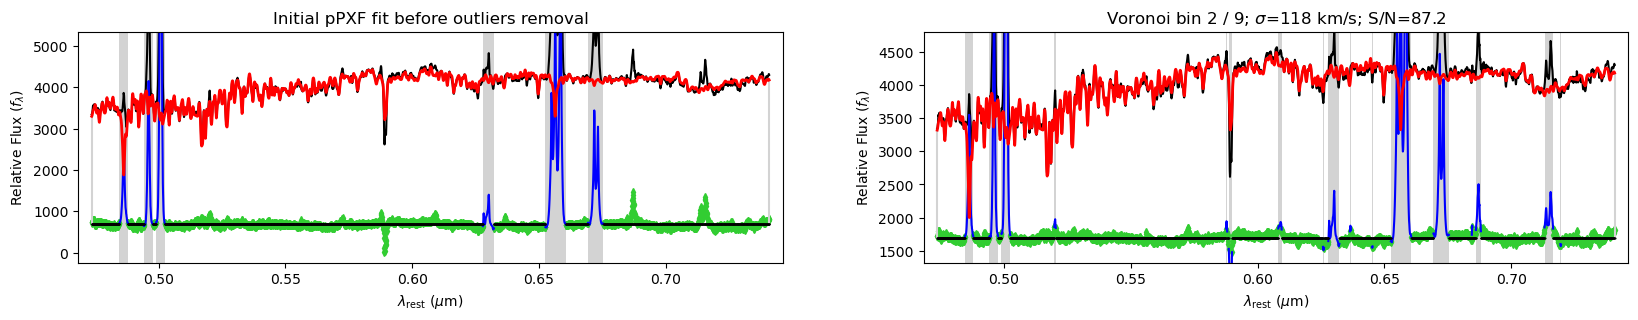

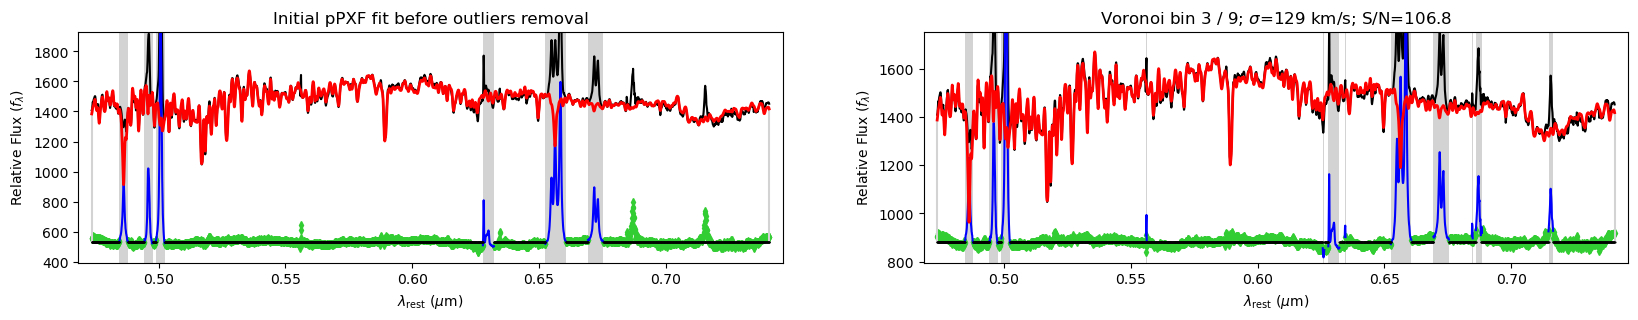

In [15]:
vel0 = 0                # Spectrum was de-redshifted. Initial guess is zero
start = [vel0, 200.]    # (km/s), starting guess for [V,sigma]

nbins = np.unique(bin_num).size
velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))
lam_gal = np.exp(s.ln_lam_gal)

for j in range(nbins):
    plot = True if j < 3 else False  # Only plot the first few spectra
    w = bin_num == j
    galaxy = np.nanmean(s.spectra[:, w], 1)
    pp, bestfit_template, sn = ppxf_fit_and_clean(stars_templates, galaxy, s.velscale, start, mask0, lam_gal, sps.lam_temp, plot=plot, quiet=not plot)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = bestfit_template
    light_weights = pp.weights.reshape(reg_dim)
    lg_age_bin[j], metalbin[j] = sps.mean_age_metal(light_weights, quiet=not plot)

    if plot:
        txt = f"Voronoi bin {j + 1} / {nbins}; $\\sigma$={sigbin[j]:.0f} km/s; S/N={sn:.1f}"
        print(txt + '\n' + '#'*78)
        plt.title(txt)

Plot a map of the stellar velocity and lgAge in the Voronoi binned data. This
is the nearest neighbour interpolation. With very few bins, the maps are
unreadable.

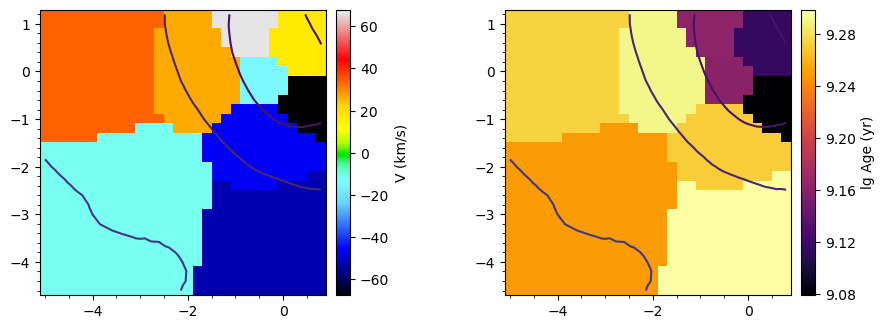

In [16]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
display_bins(s.x, s.y, bin_num, velbin, colorbar=1, label='V (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

plt.subplot(122)
display_bins(s.x, s.y, bin_num, lg_age_bin, colorbar=1, cmap='inferno', label='lg Age (yr)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

Here is the result of this Notebook when using a proper Voronoi binning with `target_sn=60`<br>
![](https://raw.githubusercontent.com/micappe/ppxf_examples/main/vel_age_maps.jpg)

## Setup the gas emission line templates

Construct a set of Gaussian emission line templates. They have the width of the instrumental LSF.


In [17]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(ln_lam_temp, lam_range_gal, s.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' 'HeI5876' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']


Create three sets of gas templates for each of the 8 emission lines which
fall within the fitted wavelength range. In this example I want three
components for each emission line and I can just replicate the same gas
templates three times. Below I add an index `_0, _1, _2` to the strings of
the original names of the emission lines. In general, one could decide to add
a second component only to certain lines (e.g. the Balmer series) and for
this one would select for the secondary kinematic components just some of the
templates of the first component.

In [18]:
ngas_comp = 3    # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

## Combine the stellar and gas templates

Here I select a single spaxel for this example. However, in a real analysys
this would be replaced by a foor loop over every spaxel

In [19]:
# j = 611  # Use this line to select a clear double line
j = 682  # Use this line for broad blended lines near the nucleus

In [20]:
galaxy = s.spectra[:, j]
noise = np.ones_like(galaxy)

Use as galaxy template the one determined at higher-S/N from the bin
containing the current spaxel. I also keep the stellar kinematic fixed to the
value determined from that bin.

In [21]:
k = bin_num[j]
template = optimal_templates[:, k]

The templates are made of a single stellar template, as fitted previously on
the bin that contain the spaxel under consideration plus a set of gas
emission lines.

In [22]:
stars_gas_templates = np.column_stack([template, gas_templates])

## Setup of pPXF input parameters

I fit the following 8 gas emission line templates, and I include three
kinematic components for each emission line

$H\beta$, $H\alpha$, [SII]6716, [SII]6731, HeI5876, [OIII]5007d, [OI]6300d, [NII]6583d

I assign `component=0` to the stellar template, and I assign two kinematic
components to all narrow lines `component=1` and `component=2`. I also
include a broad kinematic for every line `component=3`.

NOTE: in Python `[0] + [1]*8 --> [0, 1, 1, 1, 1, 1, 1, 1, 1]`

In [23]:
component = [0] + [1]*8 + [2]*8 + [3]*8

With my setup, the gas components are all `components` larger than zero

In [24]:
gas_component=np.array(component) > 0

I do not fit the stellar kinematics `component=0` (I set a negative
`moments=-2`) but use instead the previously fitted kinematic solution for
the Voronoi bin that include the spaxel under analysis. I fit two `moments=2`
(V, sigma) for all three gas components

In [25]:
moments = [-2, 2, 2, 2]

As an illustration, I set some constraints on the kinematics of some lines.
In particular, I set the (gas) velocity dispersion of the kinematic
`component=2` equal to that of `component=1`. I also set the (gas) mean
velocity of the broad `component=3` equal to the average of the velocities of
the narrow gas `component=1` and `component=2`. See the `pPXF`
[documentation](https://pypi.org/project/ppxf/) of the `tied` keyword to
understand the syntax.
In formulas:

$$\sigma_2=\sigma_1$$
$$V_3=\frac{V_1+V_2}{2}$$

In [26]:
# start = [[V0, sig0], [V1, sig1], [V2, sig2], [V3, sig3]]
ncomp = len(moments)
tied = [['', ''] for _ in range(ncomp)]     # [['', ''], ['', ''], ['', ''], ['', '']]
tied[2][1] = 'p[3]'                         # sig2 = sig1
tied[3][0] = '(p[2] + p[4])/2'              # V3 = (V1 + V2)/2

I want to avoid degeneracy between the narrow and broad gas components. For
this, I set the constraint that the velocity dispersion of the broad gas
`component=3` must be at least `sig_diff=200` km/s larger than the dispersion
of any of the narrow components. In formulas, I want to have both:

$$
\begin{cases}
\sigma_1 + \sigma_{\rm diff} < \sigma_3\\
\sigma_2 + \sigma_{\rm diff} < \sigma_3
\end{cases}
$$

Following standard practice in numerical optimization (e.g.
[HERE](https://uk.mathworks.com/help/optim/ug/linear-constraints.html)), I
express these two inequalities as linear constraints in matrix form as this
leads to an efficient optimization algorithm, with guaranteed local
convergence:

$$\mathbf{A}_{\rm ineq}\cdot \mathbf{p} < \mathbf{b}_{\rm ineq}.$$

In this example, the vector of nonlinear kinematic parameters is
$\mathbf{p}=[V_0, \sigma_0, V_1, \sigma_1, V_2, \sigma_2, V_3, \sigma_3]$
(following the same order of the `start` parameter of `pPXF`) and I can write
the above matrix equation explicitly as

$$
\begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & -1 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
V_0 \\
\sigma_0 \\
V_1 \\
\sigma_1\\
V_2 \\
\sigma_2 \\
V_3 \\
\sigma_3
\end{bmatrix}
<
\begin{bmatrix}
-\sigma_{\rm diff} \\
-\sigma_{\rm diff} \\
\end{bmatrix}.
$$

This translates into the following Python code

In [27]:
sig_diff = 200  # minimum dispersion difference in km/s
A_ineq = np.array([[0, 0, 0, 1, 0, 0, 0, -1],       # sigma2 - sigma4 < -sigma_diff
                   [0, 0, 0, 0, 0, 1, 0, -1]])      # sigma3 - sigma4 < -sigma_diff
b_ineq = np.array([-sig_diff, -sig_diff])/s.velscale  # velocities have to be expressed in pixels
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

The stellar kinematics is generally a good enough estimate for the gas one.
However, as I am using `global_search`, the values of the starting guess are
not necessary and are ignored. NOTE: the starting guess must be feasible,
namely it must satisfy the linear constraints above.

In [28]:
start = [[velbin[k], sigbin[k]],     # The stellar component=0 is fixed and this starting value will remain unchanged
         [velbin[k], 50],            # My starting guess for the velocity of all gas components is the stellar velocity
         [velbin[k], 50],            # however, this starting guess is ignored when using `global_search=True`
         [velbin[k], 500]]           # The starting guess must be feasible, namely must satisfy the constraints

As I am using `global_search`, the `bounds` below are important because they
define the region that is initially explored by the global optimizer. I
define the bounds for the gas emission lines based on the stellar velocity of
the Voronoi bin containing the spaxel that I am fitting.

In [29]:
vlim = lambda x: velbin[k] + x*np.array([-100, 100])
bounds = [[vlim(2), [20, 300]],       # Bounds are ignored for the stellar component=0 which has fixed kinematic
          [vlim(2), [20, 100]],       # I force the narrow component=1 to lie +/-200 km/s from the stellar velocity
          [vlim(6), [20, 100]],       # I force the narrow component=2 to lie +/-600 km/s from the stellar velocity
          [vlim(2), [20, 1000]]]      # I force the broad component=3 to lie +/-200 km/s from the stellar velocity

## pPXF fit of the gas emission lines

Given that this spectrum contains multiple kinematic components well
separated in velocity, the $\chi^2$ necessarily contains multiple minima. For
this reason, I set the keyword `global_search=1`. This keyword should be used
*only* when the problem has obvious multiple minima, as it is much slower and
completely unnecessary in normal situations. The use of `global_search` is
unnecessary for most galaxies, as clear multiple components are uncommon.

differential_evolution step 1: f(x)= 80294237.49721627
differential_evolution step 2: f(x)= 51352572.58091569
differential_evolution step 3: f(x)= 50523278.86783887
differential_evolution step 4: f(x)= 34655601.84188434
differential_evolution step 5: f(x)= 30924446.89915175
differential_evolution step 6: f(x)= 30924446.89915175
differential_evolution step 7: f(x)= 28295173.776449263
differential_evolution step 8: f(x)= 27950979.609366156
differential_evolution step 9: f(x)= 27950979.609366156
differential_evolution step 10: f(x)= 27780561.175413523
differential_evolution step 11: f(x)= 27780561.175413523
differential_evolution step 12: f(x)= 27481038.784128945
differential_evolution step 13: f(x)= 27481038.784128945
differential_evolution step 14: f(x)= 27418095.801762335
 Best Fit:       Vel     sigma
 comp.  0:       -13       118
 comp.  1:       -63        84
 comp.  2:       301        84
 comp.  3:       119       319
chi2/DOF: 1.029e+04; DOF: 2656; degree = 8; mdegree = 0
Global

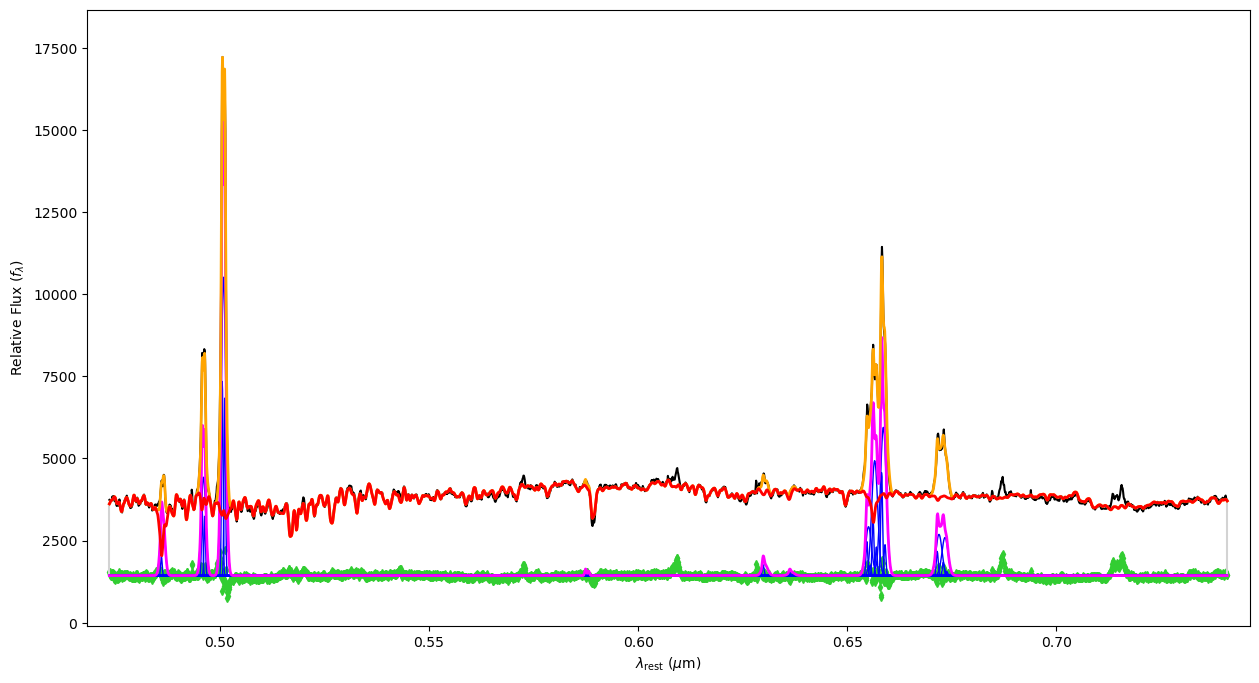

In [30]:
plt.figure(figsize=(15,8))
pp = ppxf(stars_gas_templates, galaxy, noise, s.velscale, start,
          plot=1, moments=moments, degree=8, mdegree=-1, component=component, 
          gas_component=gas_component, gas_names=gas_names, constr_kinem=constr_kinem,
          lam=lam_gal, lam_temp=sps.lam_temp, tied=tied, bounds=bounds, global_search=True)


The `pPXF` documentation [HERE](https://pypi.org/project/ppxf/#output-parameters) states:

>IMPORTANT: ``pPXF`` makes no assumptions about the input flux units: The
>returned ``.gas_flux`` has the same units and values one would measure (with
>lower accuracy) by summing the pixels values, within the given gas lines, on
>the continuum-subtracted input galaxy spectrum. This implies that, if the
>spectrum is in units of ``erg/(s cm^2 A)``, the ``.gas_flux`` returned by
>``pPXF`` should be multiplied by the pixel size in Angstrom at the line
>wavelength to obtain the integrated line flux in units of ``erg/(s cm^2)``.

For this reason, below I multiply the flux returned by `pPXF` by the pixel
size at the wavelength of each line.

In [31]:
rms = robust_sigma(galaxy - pp.bestfit, zero=1)

c_kms = 299792.458  # speed of light in km/s
names = ['Halpha', 'Hbeta' , '[NII]6583_d', '[OIII]5007_d']
for p, name in enumerate(names):
    kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
    dlam = line_wave[kk]*s.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
    flux = (pp.gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
    an = np.max(pp.gas_bestfit_templates[:, kk])/rms
    print(f"{name:12s} - Amplitude/Noise: {an:6.4g}; gas flux: {flux:6.0f} ergs/(cm^2 s)")

Halpha       - Amplitude/Noise:  25.15; gas flux:   9666 ergs/(cm^2 s)
Hbeta        - Amplitude/Noise:  8.426; gas flux:   2607 ergs/(cm^2 s)
[NII]6583_d  - Amplitude/Noise:  45.15; gas flux:  23147 ergs/(cm^2 s)
[OIII]5007_d - Amplitude/Noise:  85.06; gas flux:  35971 ergs/(cm^2 s)


Zoom into the two main emission lines. Overplot for reference the wavelength
of the main emission lines at the recession velocity measured from the
stellar kinematics. This figure is nearly the same as Fig.2 of 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)
except for the fact that here I also use the `tied` keyword. To reproduce the
figure in the paper, set ``tied = None`` before the ``pPXF`` fit.

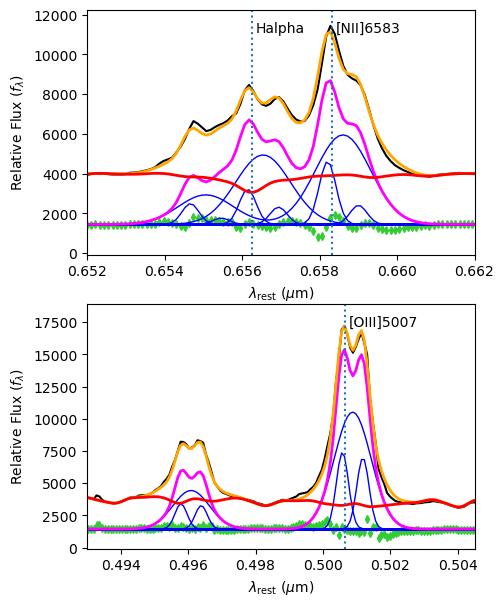

In [32]:
w = ['(1)' in c for c in gas_names]  # select first gas kinematic component
fig = plt.figure(figsize=(5, 7))

lam_ranges = [0.652, 0.662], [0.493, 0.5045]  # in micron
vel_stars = pp.sol[0][0]   # stars velocity = 0th elements of 0th kinematic component 

for j, lam_range in enumerate(lam_ranges):
    plt.subplot(len(lam_ranges), 1, j+1)
    pp.plot()   # pPXF output plot
    plt.xlim(lam_range)
    k = (1e4*lam_range[0] < pp.lam) & (pp.lam < 1e4*lam_range[1])
    ymax = np.max(pp.bestfit[k])   # max plotting range
    plt.ylim(None, ymax*1.1)
    for lam, nam in zip(line_wave[w], gas_names[w]):
        lamz = lam*np.exp(vel_stars/c_kms)/1e4   # gas emission wavelength
        if lam_range[0] < lamz < lam_range[1]:
            plt.axvline(lamz, ls=':')
            plt.text(lamz+1e-4, ymax, nam[:nam.find('_')])
plt.pause(5);